# Unsupervised Tasks

Library Imports

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import torch

Reading in Dataset

In [ ]:
df = pd.read_csv('company_esg_financial_dataset.csv')
df['GrowthRate'] = df['GrowthRate'].fillna(0)

## Clustering
Clustering is applied to the standardized financial and ESG metrics to group companies with similar quantitative profiles. Only numerical variables are included in the clustering process; categorical attributes such as Industry and Region are kept separate and used later to interpret the characteristics of each cluster. This approach reveals structure in the data without relying on predefined labels.

Imports

In [ ]:
# Use GPU if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cpu


### Data Preparation

Summarize the dataset so each company has one row by averaging numeric ESG and financial metrics.

In [ ]:
company_features = df.groupby(["CompanyID", "CompanyName", "Industry", "Region"]).agg({
    "Revenue": "mean",
    "ProfitMargin": "mean",
    "MarketCap": "mean",
    "GrowthRate": "mean",
    "ESG_Overall": "mean",
    "ESG_Environmental": "mean",
    "ESG_Social": "mean",
    "ESG_Governance": "mean",
    "CarbonEmissions": "mean",
    "WaterUsage": "mean",
    "EnergyConsumption": "mean"
}).reset_index()

Convert ESG_Overall scores into four letter grades for later comparison with clusters.

In [ ]:
bins = [0, 25, 50, 75, 100]
labels = ["D", "C", "B", "A"]

company_features["ESG_Target"] = pd.cut(
    company_features["ESG_Overall"],
    bins=bins,
    labels=labels,
    include_lowest=True
)

# Distribution check
company_features["ESG_Target"].value_counts()

ESG_Target
B    514
C    359
A    100
D     27
Name: count, dtype: int64

Select numerical features, as clustering uses only quantitative variables.

In [ ]:
feature_cols = [
    "Revenue", "ProfitMargin", "MarketCap", "GrowthRate",
    "ESG_Overall", "ESG_Environmental", "ESG_Social", "ESG_Governance",
    "CarbonEmissions", "WaterUsage", "EnergyConsumption"
]

data = company_features[feature_cols].copy()


KMeans is sensitive to scale, standardize all numerical features to have mean 0 and variance 1 before clustering.

In [ ]:
scaler = StandardScaler()
X = scaler.fit_transform(data)


### Clustering: K-Means
K-Means is used to identify groups of companies with similar numerical ESG and financial profiles. It efficiently partitions the dataset into non-overlapping clusters and is well-suited for standardized continuous features. This method provides clear, interpretable groupings.

##### Find number of clusters

KMeans requires choosing the number of clusters in advance. To select an appropriate value, the silhouette score is computed for different values of k. The score reflects how well-separated the resulting clusters are.

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

scores = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X)
    scores.append(silhouette_score(X, labels))

best_k = 2 + np.argmax(scores)
print("Best k:", best_k)


Best k: 4


##### Fit the KMeans model

Using the selected value of k, the KMeans algorithm is run on the standardized feature matrix, assigning each company to a cluster.

In [ ]:
kmeans = KMeans(n_clusters=best_k, random_state=42)
company_features["Cluster"] = kmeans.fit_predict(X)

##### Summarize cluster characteristics

Mean values of key ESG and financial metrics are computed for each cluster to help interpret the differences between groups.

In [ ]:
cluster_summary = company_features.groupby("Cluster").mean(numeric_only=True)
print(cluster_summary[["ESG_Overall","ProfitMargin","Revenue","CarbonEmissions"]])

         ESG_Overall  ProfitMargin       Revenue  CarbonEmissions
Cluster                                                          
0          41.511466      9.946623   2814.852151     9.421231e+05
1          66.684426     11.138860   3562.529620     6.344750e+05
2          59.628139     18.889827  33429.066667     7.477322e+06
3          61.012121      8.748485  71259.793939     6.927318e+07


### Clustering: Gaussian Mixture Model
Gaussian Mixture Models capture clusters as probability distributions rather than hard assignments. This allows overlapping clusters and more flexibility in shape. GMM is suitable for numerical ESG and financial features where clusters may not be perfectly spherical.

##### Selecting the number of clusters

The optimal number of components (k) is determined using the Bayesian Information Criterion (BIC). Lower BIC indicates a better balance between model fit and complexity.

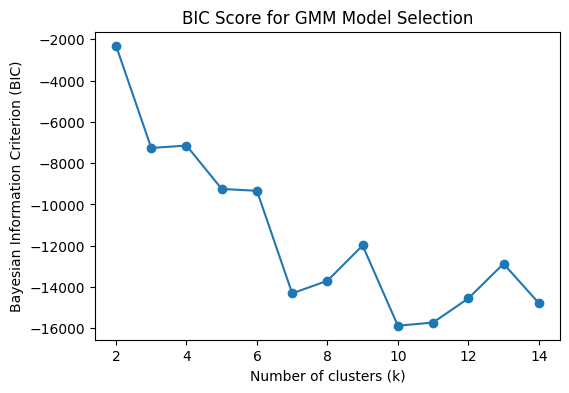

Selected k (lowest BIC): 10


In [ ]:
from sklearn.mixture import GaussianMixture

bic_scores = []
K_range = range(2, 15)

for k in K_range:
    gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=42)
    gmm.fit(X)
    bic_scores.append(gmm.bic(X))

plt.figure(figsize=(6,4))
plt.plot(K_range, bic_scores, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Bayesian Information Criterion (BIC)")
plt.title("BIC Score for GMM Model Selection")
plt.show()

best_k = K_range[np.argmin(bic_scores)]
print("Selected k (lowest BIC):", best_k)


##### Fit final GMM and assign clusters

The final GMM is fit with the selected number of components, and cluster assignments are added to the dataset.

In [ ]:
best_gmm = GaussianMixture(n_components=best_k, covariance_type='full', random_state=42)
company_features["Cluster_GMM"] = best_gmm.fit_predict(X)

##### Summarize cluster characteristics

Mean values of key ESG and financial metrics are computed for each GMM cluster to facilitate interpretation.

In [ ]:
cluster_summary_gmm = company_features.groupby("Cluster_GMM").mean(numeric_only=True)
print(cluster_summary_gmm[["ESG_Overall","ProfitMargin","Revenue","CarbonEmissions"]])

             ESG_Overall  ProfitMargin       Revenue  CarbonEmissions
Cluster_GMM                                                          
0              38.012987     10.835714   3350.729870     9.937870e+05
1              55.159740      7.867129   1419.990954     1.651623e+05
2              61.012121      8.748485  71259.793939     6.927318e+07
3              57.156337     14.994360   4599.228467     4.149777e+05
4              68.032143     19.936039  38925.102597     1.132629e+06
5              48.150562      9.221246   5173.396118     4.720405e+06
6              45.940596      5.250000   1108.492085     6.438494e+05
7              51.559209      8.818983   1255.311069     6.336763e+05
8              53.660160     14.296524  11586.055080     8.467326e+06
9              63.264630     15.820815   6429.985842     1.237437e+05


### Clustering: DBSCAN
DBSCAN identifies clusters based on density rather than predefined cluster counts. It is suitable for detecting irregularly shaped clusters and separating noise points in the dataset. The algorithm uses the standardized numerical features to assign companies to clusters or mark them as outliers.

##### Tune DBSCAN eps using k-distance

The k-distance plot helps choose eps. Because the plot can be dense, the bend (“knee”) is detected automatically using the KneeLocator package.

Selected eps (knee): 2.7811214787620613


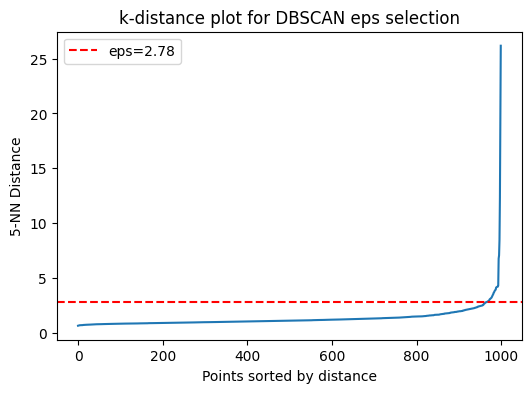

In [ ]:
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator

# Set min_samples
min_samples = 5

# Compute k-NN distances
neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X)
distances = np.sort(distances[:, min_samples-1])

# Automatic knee detection
kneedle = KneeLocator(
    range(len(distances)), distances, curve="convex", direction="increasing"
)
eps = distances[kneedle.knee]
print("Selected eps (knee):", eps)

# Optional: plot distances and knee
plt.figure(figsize=(6,4))
plt.plot(distances)
plt.axhline(y=eps, color='r', linestyle='--', label=f"eps={eps:.2f}")
plt.xlabel("Points sorted by distance")
plt.ylabel(f"{min_samples}-NN Distance")
plt.title("k-distance plot for DBSCAN eps selection")
plt.legend()
plt.show()


##### Fit DBSCAN

eps is set manually, as the k-distance knee produces only one cluster, not useful for comparision with other clustering methods. Points not assigned to any cluster are labeled as noise (-1).

In [ ]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=eps, min_samples=min_samples)
db_labels = dbscan.fit_predict(X)
company_features["Cluster_DBSCAN"] = db_labels


##### Examine cluster distribution

Counts help identify how many points are in clusters versus noise.

In [ ]:
unique, counts = np.unique(db_labels, return_counts=True)
cluster_dist = dict(zip(unique, counts))
print("Cluster distribution:", cluster_dist)
print("(Note: label -1 = noise/outliers)")

Cluster distribution: {-1: 20, 0: 980}
(Note: label -1 = noise/outliers)


### Final Comparision + Analysis

#### Group by Industry
This cell visualizes the distribution of companies across clusters for each clustering method, broken down by Industry.

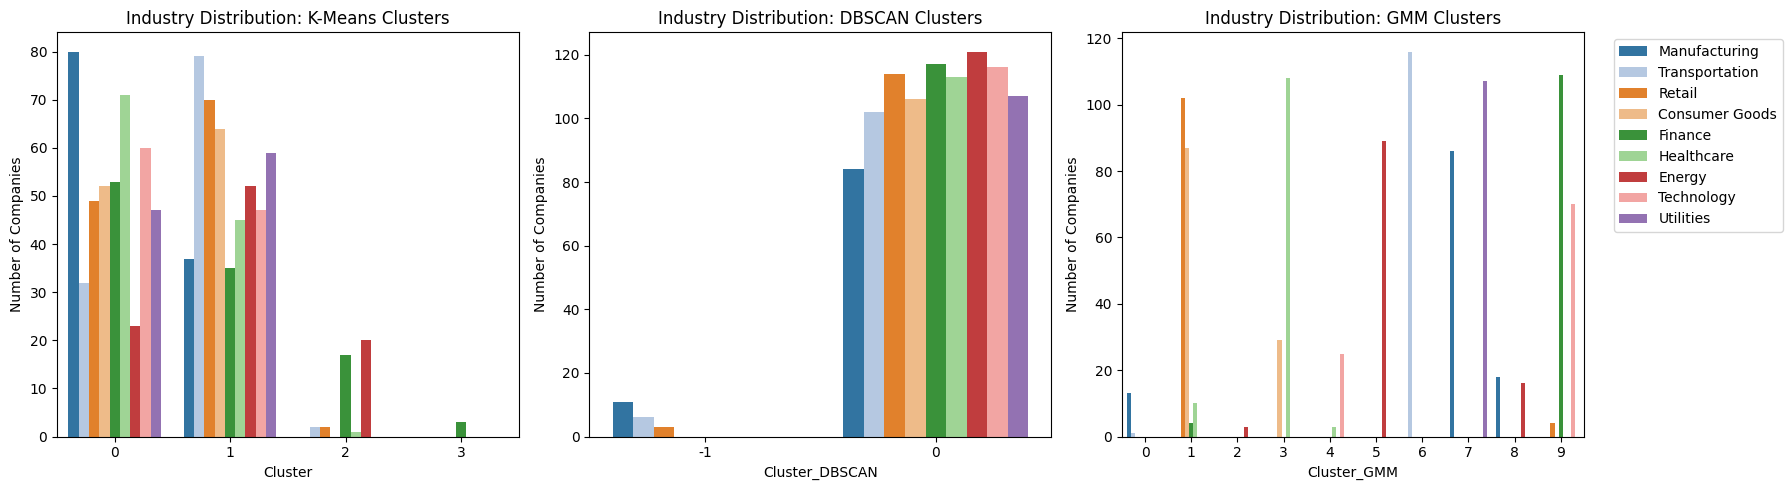

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

cluster_cols = ["Cluster", "Cluster_DBSCAN", "Cluster_GMM"]
titles = ["K-Means Clusters", "DBSCAN Clusters", "GMM Clusters"]

plt.figure(figsize=(18,5))

for i, col in enumerate(cluster_cols):
    plt.subplot(1, 3, i+1)
    sns.countplot(data=company_features, x=col, hue="Industry", palette="tab20")
    plt.title(f"Industry Distribution: {titles[i]}")
    plt.xlabel(col)
    plt.ylabel("Number of Companies")
    if i == 2:
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    else:
        plt.legend([],[], frameon=False)  # Hide legend for first two plots

plt.tight_layout()
plt.show()


The composition of the clusters across industries reveals that a few finance companies are the outliers of
K-Means, grouped in cluster 3. Otherwise, K-Means and
DBSCAN both have mixed industry distribution across
clusters, while GMM is more clearly separated.

#### Group by Region
This cell visualizes the distribution of companies across clusters for each clustering method, broken down by Region.

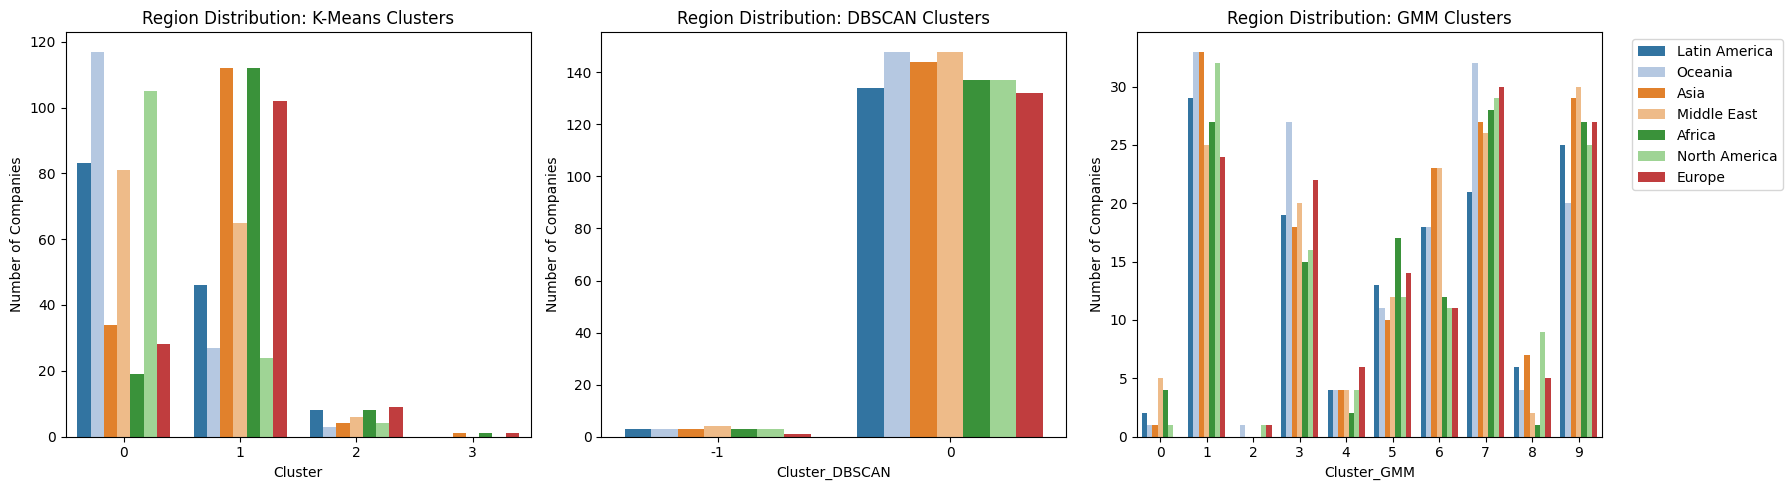

In [ ]:
cluster_cols = ["Cluster", "Cluster_DBSCAN", "Cluster_GMM"]
titles = ["K-Means Clusters", "DBSCAN Clusters", "GMM Clusters"]

plt.figure(figsize=(18,5))

for i, col in enumerate(cluster_cols):
    plt.subplot(1, 3, i+1)
    sns.countplot(data=company_features, x=col, hue="Region", palette="tab20")
    plt.title(f"Region Distribution: {titles[i]}")
    plt.xlabel(col)
    plt.ylabel("Number of Companies")
    if i == 2:
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    else:
        plt.legend([],[], frameon=False)  # Hide legend for first two plots

plt.tight_layout()
plt.show()


We observe little to no geographical correlation with clusters for each method.

#### PCA Clusters

We compare the clusters obtained from each method,
projected onto the first two principal components.

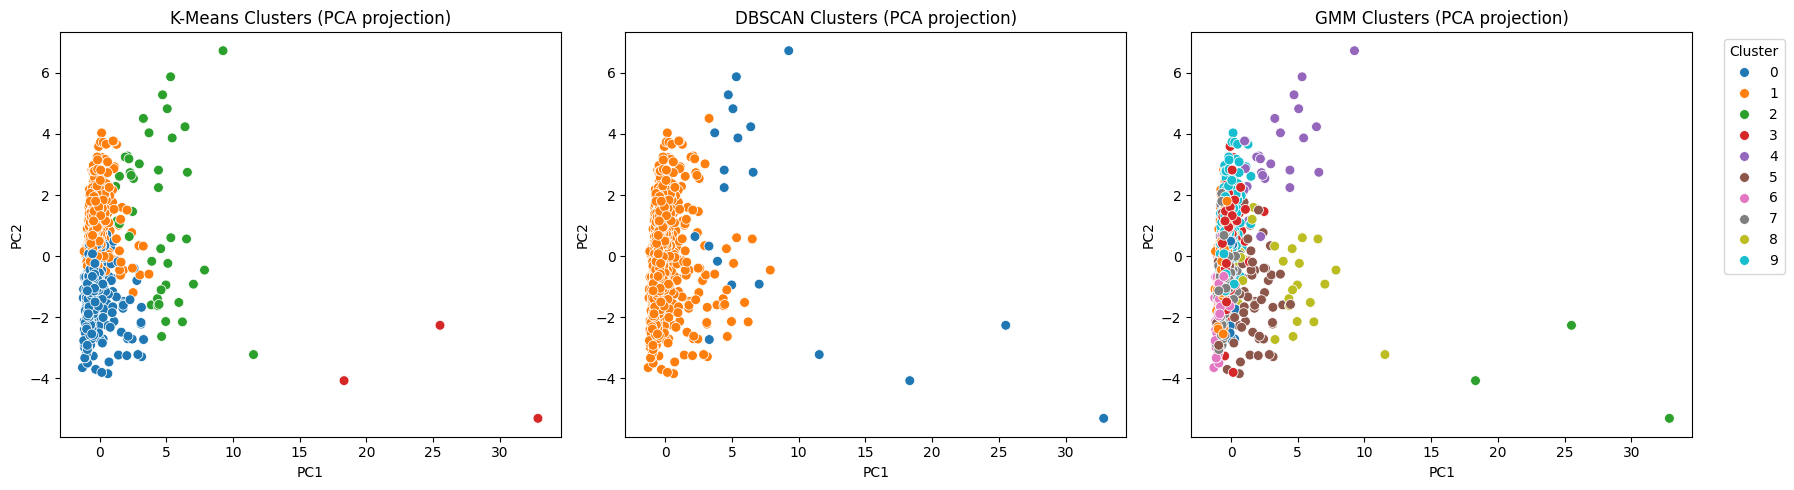

In [ ]:
from sklearn.decomposition import PCA

# Compute PCA once
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X)

cluster_cols = ["Cluster", "Cluster_DBSCAN", "Cluster_GMM"]
titles = ["K-Means Clusters", "DBSCAN Clusters", "GMM Clusters"]

plt.figure(figsize=(18,5))

for i, col in enumerate(cluster_cols):
    plt.subplot(1, 3, i+1)
    sns.scatterplot(
        x=pca_result[:,0],
        y=pca_result[:,1],
        hue=company_features[col],
        palette="tab10",
        s=50,
        legend=False if i < 2 else True  # Only show legend on last plot
    )
    plt.title(f"{titles[i]} (PCA projection)")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    if i == 2:
        plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


K-Means produced the most well-defined clusters, while the
majority of companies were in the same cluster in DBSCAN.
GMM has more clusters, but bears some resemblance to
K-Means’ clusters.

#### Group by ESG_Target

This cell visualizes the distribution of companies across clusters for each clustering method, broken down by ESG_Target. While ESG_Overall was part of the clustering, it pertains to our overall classification task, so is worth viewing.

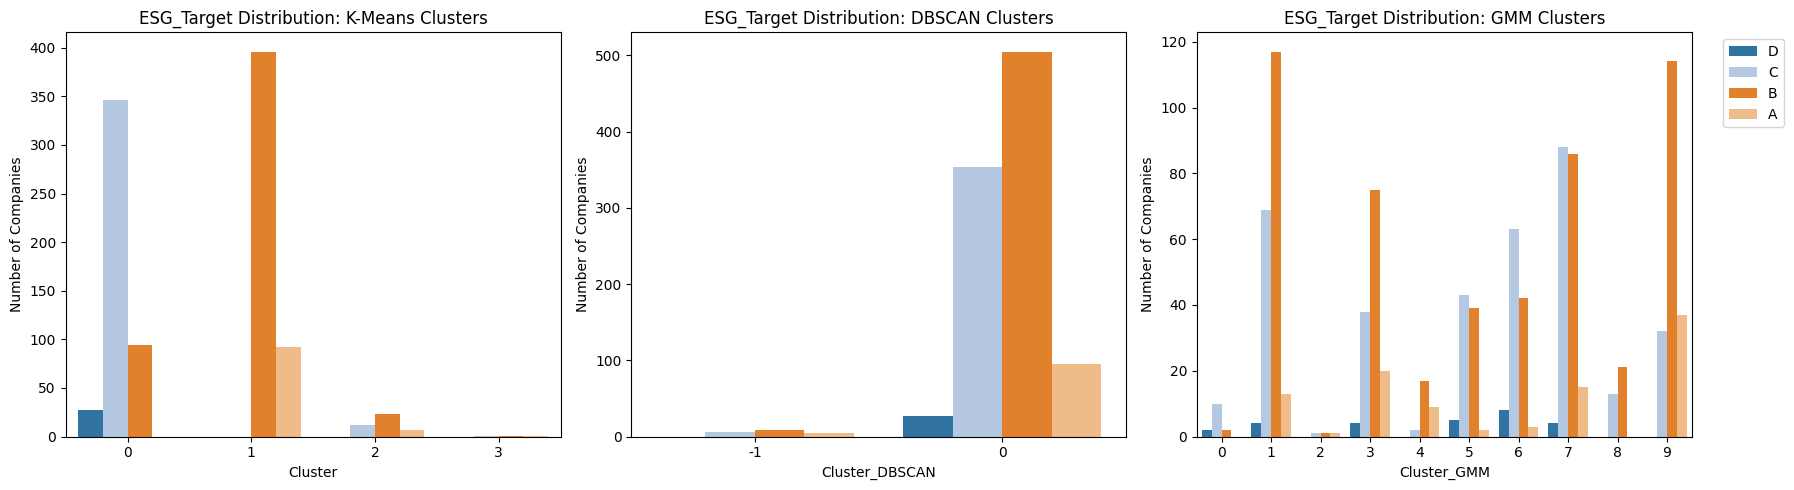

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

cluster_cols = ["Cluster", "Cluster_DBSCAN", "Cluster_GMM"]
titles = ["K-Means Clusters", "DBSCAN Clusters", "GMM Clusters"]

plt.figure(figsize=(18,5))

for i, col in enumerate(cluster_cols):
    plt.subplot(1, 3, i+1)
    sns.countplot(data=company_features, x=col, hue="ESG_Target", palette="tab20")
    plt.title(f"ESG_Target Distribution: {titles[i]}")
    plt.xlabel(col)
    plt.ylabel("Number of Companies")
    if i == 2:
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    else:
        plt.legend([],[], frameon=False)  # Hide legend for first two plots

plt.tight_layout()
plt.show()


Examination shows that different ESG thresholds are concentrated
in specific K-Means clusters, with cluster 0 low and cluster 1 high. DBSCAN has most companies
as cluster 0 (noise) and similar ESG thresholds in the smaller
clusters, while GMM has a fairly even threshold distribution.

Clustering the companies based on standardized ESG and financial metrics revealed meaningful groupings with different characteristics. K-Means produced well-separated clusters that captured variation in ESG scores and financial performance. GMM identified clusters with overlapping boundaries, reflecting probabilistic membership, while DBSCAN highlighted dense regions and flagged outliers as noise. Comparing cluster composition by industry showed that some clusters align with specific industries, though several clusters mix companies across sectors, suggesting that ESG and financial metrics provide additional structure beyond industry categories. Overall, clustering helped uncover patterns and similarities among companies that can inform further analysis or decision-making. Future improvement may involve clustering without any ESG scores to determine if the other features produce similar clusters.

## Ranking

In [ ]:
# Rank companies by ESG score for each year
df["ESG_Rank"] = df.groupby("Year")["ESG_Overall"].rank(
    method="dense", ascending=False
)

df_sorted = df.sort_values(by=["Year", "ESG_Rank"])

# top 5 per year
top5_per_year = df_sorted.groupby("Year").head(5)
print(top5_per_year[["Year", "CompanyName", "Region", "Industry", "ESG_Overall", "ESG_Rank"]])


       Year  CompanyName         Region        Industry  ESG_Overall  ESG_Rank
5247   2015  Company_478         Europe         Finance         92.9       1.0
5181   2015  Company_472         Europe      Healthcare         92.4       2.0
4873   2015  Company_444         Europe         Finance         91.7       3.0
3872   2015  Company_353         Europe         Finance         90.2       4.0
9559   2015  Company_870  Latin America         Finance         90.1       5.0
5248   2016  Company_478         Europe         Finance         94.8       1.0
5182   2016  Company_472         Europe      Healthcare         92.6       2.0
4874   2016  Company_444         Europe         Finance         91.7       3.0
2300   2016  Company_210        Oceania          Retail         91.3       4.0
3873   2016  Company_353         Europe         Finance         90.9       5.0
5249   2017  Company_478         Europe         Finance         96.0       1.0
5183   2017  Company_472         Europe      Healthc

### Plot associated

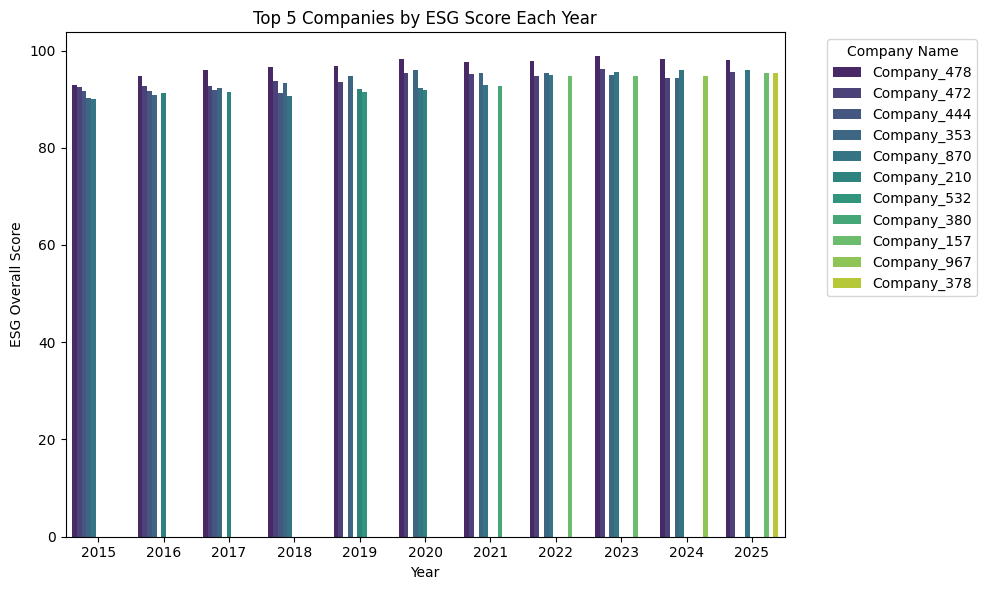

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(
    data=top5_per_year,
    x="Year",
    y="ESG_Overall",
    hue="CompanyName",
    palette="viridis"
)
plt.title("Top 5 Companies by ESG Score Each Year")
plt.ylabel("ESG Overall Score")
plt.xlabel("Year")
plt.legend(title="Company Name", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Notably, **Company\_478** consistently ranks first across all years, while **Company\_353** and **Company\_472** also appear regularly in the top positions, demonstrating sustained ESG excellence.
The majority of companies operate in the **financial** sector. And the majority of companies are located in **Europe**.
This ranking approach highlights companies with the most stable and high ESG performance over time.
Another interpretation is that the dominance of European and financial-sector companies in the rankings may reflect structural and regulatory advantages. Europe has some of the world’s most stringent ESG frameworks, which encourage stronger reporting practices and more mature sustainability strategies. Similarly, financial institutions are often early adopters of ESG standards because they integrate environmental and social risks directly into their investment and lending decisions. Together, these factors may create a built-in advantage that elevates European financial firms to the top of the ESG rankings. I see it for example at BNP Paribas during my internship where I worked on a ESG project.